<a href="https://colab.research.google.com/github/christopher-ell/Deep_Learning_Begin/blob/master/10_Custom_Training_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough

In [24]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Execution: {}".format(tf.executing_eagerly()))

Tensorflow Version: 1.12.0
Eager Execution: True


**The Iris Classification Problem**

Import and Pars the Training Dataset

In [25]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname = os.path.basename(train_dataset_url), 
                                          origin = train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /root/.keras/datasets/iris_training.csv


Inspect The Data

In [26]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [27]:
# Column order in csv file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'speices']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: speices


In [0]:
class_names = ['Iris Setosa', 'Iris Versicolor', 'Iris Virginica']

Create a tf.data.dataset

In [0]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names = column_names,
    label_name = label_name,
    num_epochs = 1)

In [30]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=123200, shape=(32,), dtype=float32, numpy=
              array([4.9, 5. , 5. , 6. , 7.7, 6.3, 6.5, 4.4, 5.4, 5.6, 6.2, 6.1, 5.8,
                     4.7, 6.4, 6.5, 5.7, 4.7, 6.8, 5.1, 6.1, 5.4, 6.8, 4.9, 6.7, 4.8,
                     6. , 5. , 6.7, 7.6, 6.9, 4.9], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=123201, shape=(32,), dtype=float32, numpy=
              array([3. , 2.3, 3.4, 2.9, 2.6, 3.4, 3.2, 2.9, 3.7, 2.9, 2.8, 3. , 2.7,
                     3.2, 3.2, 3. , 2.8, 3.2, 3.2, 3.5, 2.9, 3.9, 2.8, 3.1, 3.3, 3. ,
                     2.2, 3.4, 3. , 3. , 3.2, 2.4], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=123198, shape=(32,), dtype=float32, numpy=
              array([1.4, 3.3, 1.5, 4.5, 6.9, 5.6, 5.1, 1.4, 1.5, 3.6, 4.8, 4.9, 5.1,
                     1.3, 5.3, 5.2, 4.1, 1.6, 5.9, 1.4, 4.7, 1.7, 4.8, 1.5, 5.7, 1.4,
                     5. , 1.6, 5. , 6.6

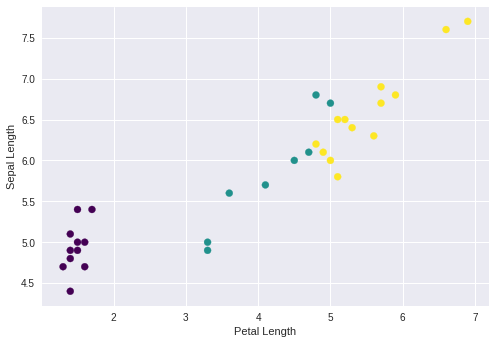

In [31]:
plt.scatter(features['petal_length'],
           features['sepal_length'],
           c = labels,
           cmap = 'viridis')

plt.xlabel("Petal Length")
plt.ylabel("Sepal Length");

In [0]:
def pack_features_vector(features, labels):
  """Pack the features into a single array"""
  features = tf.stack(list(features.values()), axis = 1)
  return features, labels

In [33]:
train_dataset = train_dataset.map(pack_features_vector)

features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.7 3.  6.1 2.3]
 [6.3 2.7 4.9 1.8]
 [5.  3.6 1.4 0.2]
 [6.1 2.6 5.6 1.4]
 [6.  2.9 4.5 1.5]], shape=(5, 4), dtype=float32)


**Select The Type of Model**

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)), ## Input shape required
    tf.keras.layers.Dense(10, activation = tf.nn.relu),
    tf.keras.layers.Dense(3)
])

**Using The Model**

In [35]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=123349, shape=(5, 3), dtype=float32, numpy=
array([[ 1.3911598 , -0.8721247 ,  0.4052949 ],
       [ 1.1698344 , -0.7464029 ,  0.29698932],
       [ 1.5382977 , -0.6849928 ,  1.3240206 ],
       [ 1.009401  , -0.7805333 ,  0.5322597 ],
       [ 1.153231  , -0.7450854 ,  0.26308107]], dtype=float32)>

In [36]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=123355, shape=(5, 3), dtype=float32, numpy=
array([[0.6769909 , 0.07041269, 0.2525964 ],
       [0.63900995, 0.09403647, 0.26695362],
       [0.52209044, 0.0565175 , 0.4213921 ],
       [0.5594324 , 0.09340907, 0.3471585 ],
       [0.64085525, 0.09601334, 0.26313144]], dtype=float32)>

In [37]:
print("Predictions: {} ".format(tf.argmax(predictions, axis = 1)))
print("Labels: {} ".format(labels))

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
Labels: [2 2 0 2 1 2 1 2 1 2 1 1 0 0 0 0 2 2 0 0 2 2 1 1 0 0 1 1 2 1 0 1] 


**Define The Loss and Gradient Function**

In [38]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels = y, logits = y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.4389609098434448


In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)

global_step = tf.contrib.eager.Variable(0)

In [41]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                         loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                         loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.4389609098434448
Step: 1,         Loss: 1.3202431201934814


In [42]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.contrib.eager.metrics.Mean()
  epoch_accuracy = tf.contrib.eager.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type = tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.197, Accuracy: 41.667%
Epoch 050: Loss: 0.389, Accuracy: 90.000%
Epoch 100: Loss: 0.265, Accuracy: 95.000%
Epoch 150: Loss: 0.194, Accuracy: 99.167%
Epoch 200: Loss: 0.145, Accuracy: 97.500%


**Visualising The Loss Function Over Time**